# Conditional Generative Adversarial Networks

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

## Constants

In [2]:
DATA_DIR = "/home/SharedData/intern_sayan/GAN/MNIST"

CHECKPOINT_DIR = "/home/SharedData/intern_sayan/GAN/"
CHECKPOINT_G = "mnist_cgan_gen.pth"
CHECKPOINT_D = "mnist_cgan_dis.pth"

SHOULD_CHECKPOINT = True
LOAD_CHECKPOINT = False

!mkdir -p cgan_images

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
CUDA = 0
BATCH_SIZE = 64
EPOCHS = 120

img_size = 28
img_shape = (1, img_size, img_size)

lr_g = 0.0002
lr_d = 0.00002

latent_dim = 100
n_classes = 10

## Data

In [3]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)


print(f"# train batches: {len(dataloader)}")

print(f"train image: {dataloader.dataset[0][0].size()}")

# train batches: 938
train image: torch.Size([1, 28, 28])


## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [  nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1)
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


## Training

In [6]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Generator & Discriminator
generator = Generator(n_classes=n_classes,
                      latent_dim=latent_dim)
discriminator = Discriminator(n_classes=n_classes)

if CUDA is not None:
    adversarial_loss.cuda()
    generator.cuda()
    discriminator.cuda()
    
if LOAD_CHECKPOINT:
    generator.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,
                                                      CHECKPOINT_G)))
    discriminator.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,
                                                          CHECKPOINT_D)))
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))


# Utils
FloatTensor = torch.cuda.FloatTensor if CUDA is not None else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if CUDA is not None else torch.LongTensor   

[Epoch 120/120] [D loss: 160.17027283] [G loss: 426.88705444] in 7.98 secs 


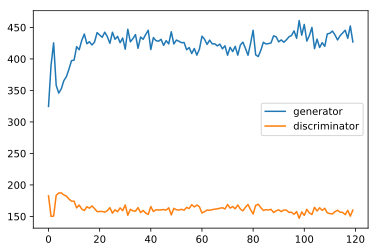

In [7]:
from IPython.display import clear_output
from tqdm import tqdm_notebook

losses = {"generator" : list(), "discriminator": list()}

def display_progress(delta, epoch, epoch_d_loss, epoch_g_loss):
    clear_output(True)
    
    print(f"[Epoch {(epoch+1):3}/{EPOCHS}] [D loss: {epoch_d_loss:.8f}] [G loss: {epoch_g_loss:.8f}] in {delta:.2f} secs ")
    
    plt.plot(range(len(losses["generator"])), losses["generator"], "tab:blue")
    plt.plot(range(len(losses["discriminator"])), losses["discriminator"], "tab:orange")

    plt.legend(["generator", "discriminator"])
    
    plt.show()

    
def sample_image(epoch):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    n_row = 8
    # Sample noise
    z = torch.autograd.Variable(FloatTensor(np.random.normal(0, 1, (n_row**2, latent_dim))))

    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = torch.autograd.Variable(LongTensor(labels))

    gen_imgs = generator(z, labels)

    save_image(gen_imgs.data, "cgan_images/epoch_{}.png".format(epoch), nrow=n_row, normalize=True)


for epoch in range(EPOCHS):
    epoch_g_loss, epoch_d_loss = 0,0
    delta = time.time()
    
    for batch_idx, (imgs, labels) in tqdm_notebook(enumerate(dataloader)):
        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = torch.autograd.Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = torch.autograd.Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = torch.autograd.Variable(imgs.type(FloatTensor))
        labels = torch.autograd.Variable(labels.type(LongTensor))
        
        
        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.autograd.Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = torch.autograd.Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        
        epoch_g_loss += g_loss.detach().cpu().float()
        epoch_d_loss += d_loss.detach().cpu().float()        
        
    delta = time.time() - delta
    
    sample_image(epoch)
    
    losses["generator"].append(epoch_g_loss)
    losses["discriminator"].append(epoch_d_loss)
    
    if SHOULD_CHECKPOINT:
        torch.save(generator.state_dict(), os.path.join(CHECKPOINT_DIR,
                                                        CHECKPOINT_G))
        torch.save(discriminator.state_dict(), os.path.join(CHECKPOINT_DIR,
                                                            CHECKPOINT_D))
    
    display_progress(delta, epoch, epoch_d_loss, epoch_g_loss)
        

## Visualisation

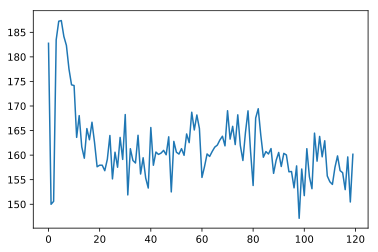

In [8]:
plt.plot(range(len(losses["discriminator"])), losses["discriminator"])

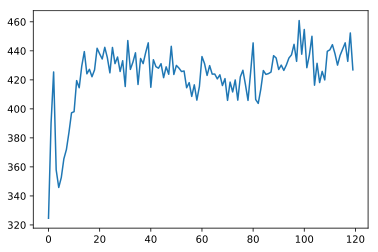

In [9]:
plt.plot(range(len(losses["generator"])), losses["generator"])

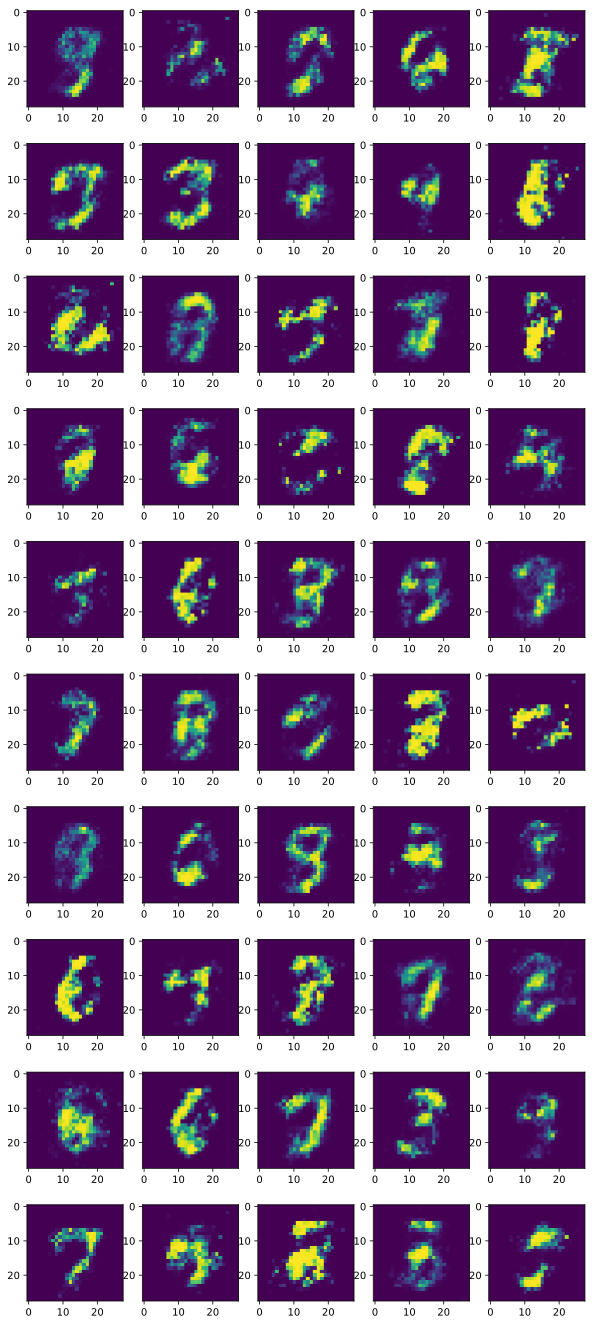

In [10]:
# Random sampling for inference

n_row = n_classes
n_col = 5


fig = plt.figure()
fig.set_figheight(24)
fig.set_figwidth(10)

for row in range(n_row):
    z = torch.autograd.Variable(FloatTensor(np.random.normal(0, 1, (n_col, latent_dim))))
    
    labels = np.array([row for _ in range(n_col)])
    labels = torch.autograd.Variable(LongTensor(labels))
    
    image = generator(z, labels).detach().cpu().numpy()
        
    for col in range(n_col):
        index = row * n_col + col
        a = fig.add_subplot(n_row, n_col, index + 1)
        
        plt.imshow(image[col].reshape(img_size, img_size))